# Plot wet snow RMSE netcdfs

Updated September 7, 2023

Plot wet snow RMSE and fraction of dry snow per different wet snow parameters.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from glob import glob
from datetime import datetime
import sys
sys.path.append('../../../spicy-snow/')

from spicy_snow.processing.snow_index import calc_delta_cross_ratio, calc_delta_gamma, \
    clip_delta_gamma_outlier, calc_snow_index, calc_snow_index_to_snow_depth
from spicy_snow.processing.wet_snow import id_newly_wet_snow, id_wet_negative_si, \
    id_newly_frozen_snow, flag_wet_snow
from spicy_snow.retrieval import retrieval_from_parameters

from dask.distributed import Client


## Choose site

In [2]:
directory = 'rmse_test_wet_snow'


which_site = 1

results1 = sorted(glob(f'{directory}/*wet*.nc'))
results2 = sorted(glob(f'{directory}/*no*.nc'))
results3 = sorted(glob(f'{directory}/*valid*.nc'))

wet_snow = xr.open_dataarray(results1[which_site])
all_snow = xr.open_dataarray(results2[which_site])
frac_valid = xr.open_dataarray(results3[which_site])

wet_snow = wet_snow.sel(freeze_snow_thresh=slice(0.5,2))
all_snow = all_snow.sel(freeze_snow_thresh=slice(0.5,2))
frac_valid = frac_valid.sel(freeze_snow_thresh=slice(0.5,2))

all_rmse = xr.concat([wet_snow,all_snow],'wet_or_all')
normalized_rmse = wet_snow/all_snow


## Plot RMSE and fraction dry pixels

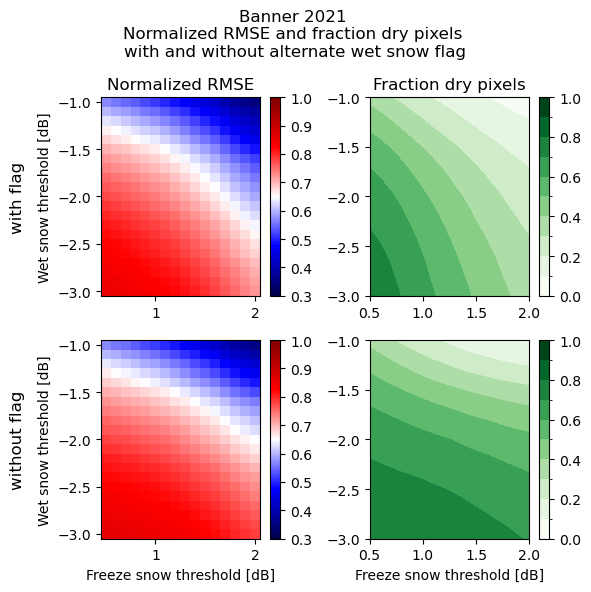

In [3]:
f,ax=plt.subplots(2,2,figsize=(6,6))

normalized_rmse.sel(SI_thresh=0).plot(ax=ax[0,0],vmin=0.3,vmax=1,cmap='seismic')
frac_valid.sel(SI_thresh=0).plot.contourf(ax=ax[0,1],vmin=0,vmax=1,levels=11,cmap='Greens')


normalized_rmse.sel(SI_thresh=-100).plot(ax=ax[1,0],vmin=0.3,vmax=1,cmap='seismic')
frac_valid.sel(SI_thresh=-100).plot.contourf(ax=ax[1,1],vmin=0,vmax=1,levels=11,cmap='Greens')
#ax[1,0].set_title('Normalized RMSE')
#ax[1,1].set_title('Fraction of pixels dry')
ax[1,0].set_title('')
ax[1,1].set_title('')

ax[0,0].set_title('Normalized RMSE')
ax[0,1].set_title('Fraction dry pixels')

ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')

ax[1,1].set_ylabel('')

ax[0,0].set_ylabel('Wet snow threshold [dB]')
ax[1,0].set_ylabel('Wet snow threshold [dB]')

ax[1,0].set_xlabel('Freeze snow threshold [dB]')
ax[1,1].set_xlabel('Freeze snow threshold [dB]')

#for axs in ax:
#    axs.set_xlim([0.5,2])


f.suptitle('Banner 2021 \nNormalized RMSE and fraction dry pixels \nwith and without alternate wet snow flag')

rows=['with flag','without flag']
pad = 5
for ax, row in zip(ax[:,0], rows):
    ax.annotate(row,xy=(0, 0.5), xytext=(-ax.yaxis.labelpad-pad,0),                    
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center',rotation=90)
plt.tight_layout()

f.savefig('figures/RMSE_fracdry_mesh.png',dpi=600)

## 2D slices of RMSE and fraction dry pixels

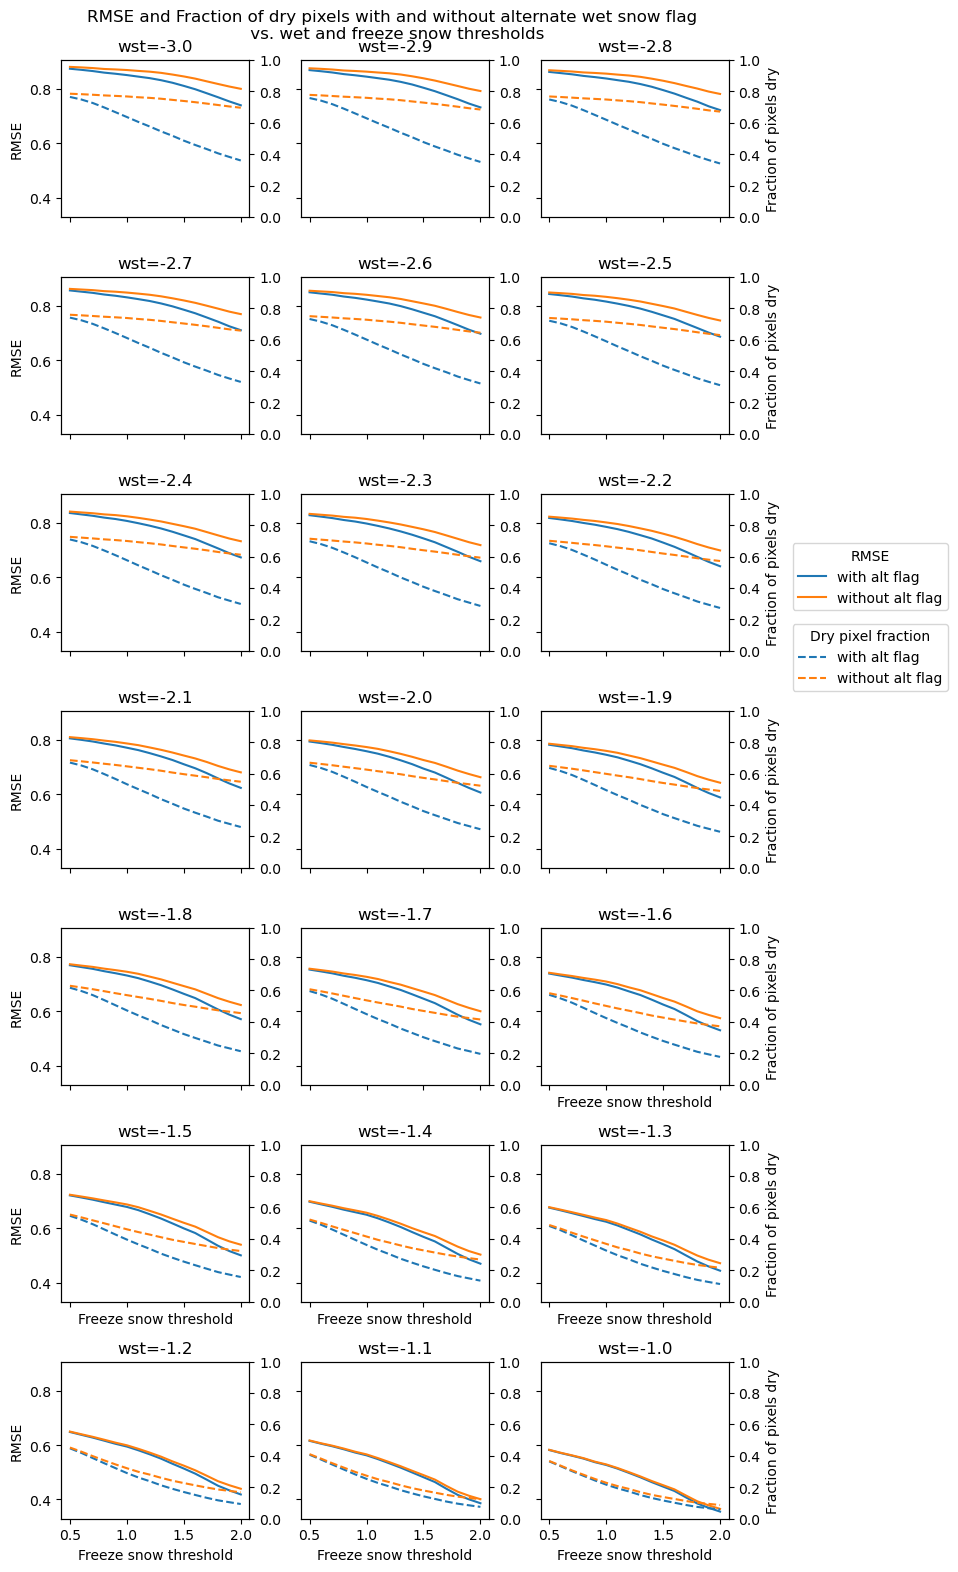

In [4]:
#sit = 0
col_wrap = 3
counter = 0
f=wet_snow.plot(hue='SI_thresh',col='wet_snow_thresh',col_wrap=col_wrap,sharey=True,add_legend=False)
f.fig.set_size_inches(8,16) #10,21

for wst,ax in zip(all_rmse.wet_snow_thresh,f.axs.ravel()):
    frac_ax = ax.twinx()
    fv = frac_valid.sel(wet_snow_thresh=wst).plot(ax=frac_ax,hue='SI_thresh',label='dry pixel fraction',linestyle='--',add_legend=False)
    frac_ax.set_ylim([0,1])
    frac_ax.set_title('')
    #ax.axvline(wet_snow.sel(SI_thresh=sit,wet_snow_thresh=wst).idxmin(),color='black',linestyle='--')
    ax.set_title('')
    #dry_percent = 100*frac_valid.sel(SI_thresh=sit,wet_snow_thresh=wst,freeze_snow_thresh=float(wet_snow.sel(SI_thresh=sit,wet_snow_thresh=wst).idxmin()))
    ax.set_title(f'wst={wst:0.1f}')

    if np.mod(counter,col_wrap) == 0:
        ax.set_ylabel('RMSE') 
    if np.mod(counter,col_wrap) == col_wrap-1:
        frac_ax.set_ylabel('Fraction of pixels dry') 
    if wst > -1.69:
        ax.set_xlabel('Freeze snow threshold')
    counter = counter + 1

f.fig.legend(labels=['with alt flag','without alt flag'], title= 'RMSE', loc='lower right',bbox_to_anchor=(1.2, 0.6))
f.fig.legend(handles=fv,labels=['with alt flag','without alt flag'], title='Dry pixel fraction', loc='upper right',bbox_to_anchor=(1.2, 0.6))

f.fig.suptitle('RMSE and Fraction of dry pixels with and without alternate wet snow flag \n vs. wet and freeze snow thresholds')

plt.tight_layout()

f.fig.savefig('figures/RMSE_fracdry_subplots.png',dpi=600)